# ОИАД. Лабораторная работа №2

In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('students_simple.csv')
columns = ['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp', 'friends', 'test_time']

In [3]:
N = 3
print(columns[N % 5], columns[(N * N) % 5 + 5])

iq test_time


In [4]:
data1 = np.array(df['iq'])
data2 = np.array(df['test_time'])

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [5]:
def Fechner(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    dx = x - x_mean
    dy = y - y_mean
    
    mask = (dx != 0) & (dy != 0)
    dx = dx[mask]
    dy = dy[mask]
    
    mul = dx * dy
    C = np.sum(mul > 0)
    D = np.sum(mul < 0)
    
    return (C - D) / (C + D)

def Pearson(x, y, confidence=0.95):
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))

    r = 0.0
    if denominator != 0:
        r = numerator / denominator
        
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)             
    alpha = 1 - confidence
    z_crit = scipy.stats.norm.ppf(1 - alpha / 2)
    z_low, z_high = z - z_crit * se, z + z_crit * se
    r_low, r_high = np.tanh(z_low), np.tanh(z_high)
    return r, (r_low, r_high)

def Spearman(x, y):
    x_ranks = scipy.stats.rankdata(x, method='average')
    y_ranks = scipy.stats.rankdata(y, method='average')
    spearman, _ = Pearson(x_ranks, y_ranks)
    return spearman

def Kendall(x, y):
    x_ranks = scipy.stats.rankdata(x, method='average')
    y_ranks = scipy.stats.rankdata(y, method='average')
    C = 0
    D = 0
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            dx = x_ranks[i] - x_ranks[j]
            dy = y_ranks[i] - y_ranks[j]
            if dx * dy > 0:
                C += 1
            elif dx * dy < 0:
                D += 1    
    return (C - D) / (C + D)

In [6]:
print(f"Фехнер: {Fechner(data1, data2)}")
r, (r_low, r_high) = Pearson(data1, data2)
print(f"Пирсон: {r:.4f}")

print(f"Спирмен: {Spearman(data1, data2)}")
print(f"Кенделл: {Kendall(data1, data2)}")

Фехнер: -0.7
Пирсон: -0.6818
Спирмен: -0.6823485616883068
Кенделл: -0.5080213903743316


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

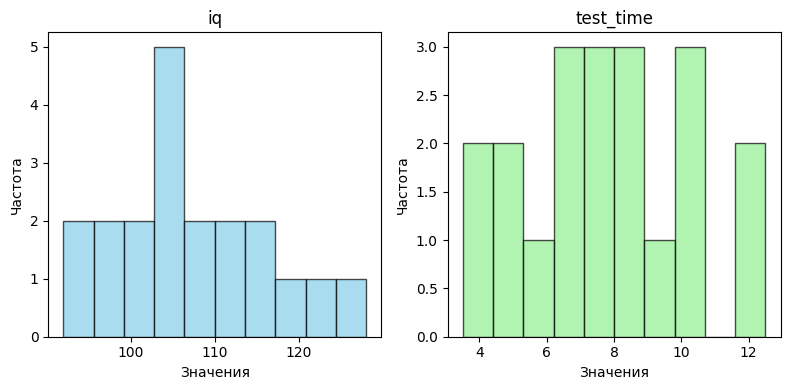

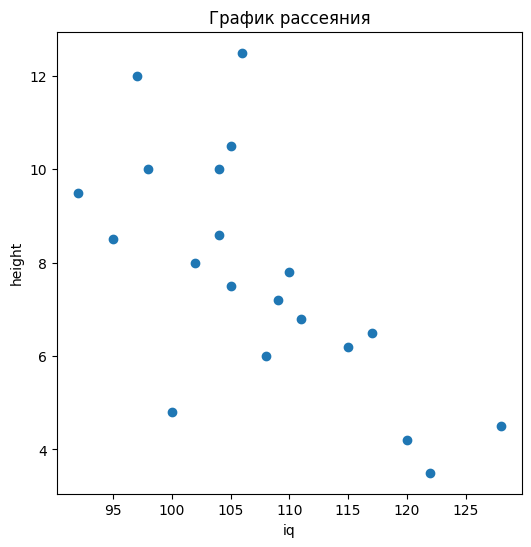

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(data1, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('iq')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(data2, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('test_time')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(data1, data2)
plt.title('График рассеяния')
plt.xlabel('iq')
plt.ylabel('height')
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. Линейная, $y=w_1 x + w_0$
2. Квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. Гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. Показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

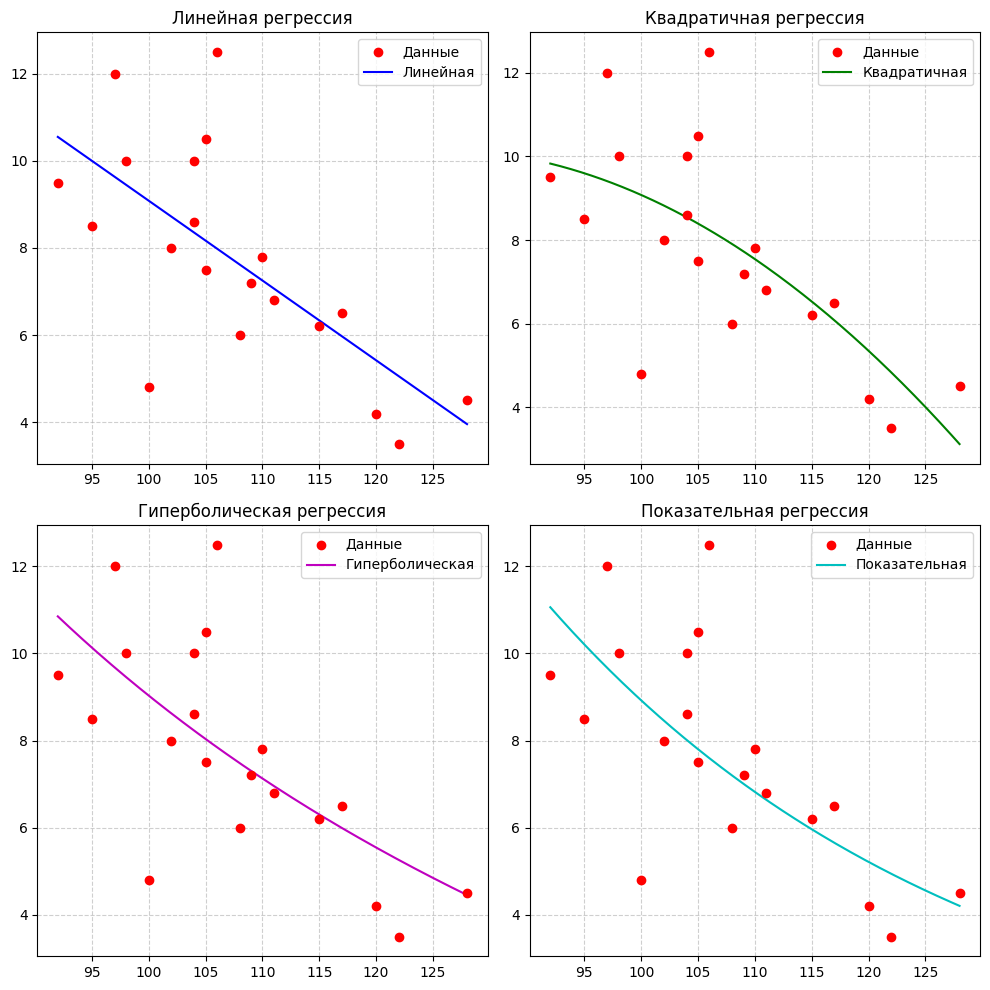

In [8]:
x = data1.reshape(-1, 1)
y = data2
x_smooth = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)

linear = LinearRegression().fit(x, y)
quadratic = LinearRegression().fit(np.hstack([x**2, x]), y)
hyperbolic = LinearRegression().fit(1 / x, y)
logistic = LinearRegression().fit(x, np.log(y))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

for ax in axs:
    ax.scatter(x, y, color='red', label='Данные', zorder=5)
    ax.grid(True, linestyle='--', alpha=0.6)

axs[0].plot(x_smooth, linear.predict(x_smooth), 'b-', label='Линейная')
axs[0].set_title('Линейная регрессия')
axs[0].legend()

axs[1].plot(x_smooth, quadratic.predict(np.hstack([x_smooth**2, x_smooth])), 'g-', label='Квадратичная')
axs[1].set_title('Квадратичная регрессия')
axs[1].legend()

axs[2].plot(x_smooth, hyperbolic.predict(1/ x_smooth), 'm-', label='Гиперболическая')
axs[2].set_title('Гиперболическая регрессия')
axs[2].legend()

axs[3].plot(x_smooth, np.exp(logistic.predict(x_smooth)), 'c-', label='Показательная')
axs[3].set_title('Показательная регрессия')
axs[3].legend()

plt.tight_layout()
plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие модели данным с помощью критерия Фишера

In [9]:
def Fisher(y_true, y_pred, p=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    
    SST = np.sum((y_true - y_true.mean()) ** 2)
    SSE = np.sum((y_true - y_pred) ** 2)
    SSR = SST - SSE
    
    df_reg = p
    df_res = n - p - 1
    
    F = (SSR / df_reg) / (SSE / df_res)
    p_val = 1 - scipy.stats.f.cdf(F, df_reg, df_res)
    
    return F, p_val

In [10]:
Fisher(y, linear.predict(x))

(np.float64(15.636685271069137), np.float64(0.0009297756497628207))

In [11]:
Fisher(y, quadratic.predict(np.hstack([x**2, x])), 2)

(np.float64(7.925772503122604), np.float64(0.0036990613846550335))

In [12]:
Fisher(y, hyperbolic.predict(1 / x))

(np.float64(14.198745540558747), np.float64(0.0014079312109478437))

In [13]:
Fisher(y, np.exp(logistic.predict(x)))

(np.float64(12.898539949577527), np.float64(0.002086488284626986))

## 5. Выводы
Сделать вывод по каждому пункту.

1. Коэффициент Фехнера: -0.70 => заметная отрицательная направленность, пары чаще изменяются в противоположную сторону.
2. Коэффициент Пирсона -0.68 => умеренно сильная отрицательная линейная связь.
3. Коэффициент Спирмена –0.68 => слабая монотонная связь.
4. Коэффициент Кенделла –0.51 => очень слабая согласованность пар.
5. Критерий Фишера все построенные модели значимы (p < 0.05), гипотеза об отсутствии связи отклоняется.
   
В целом, для признаков IQ и test_time присутствует заметная обратная зависимость: чем выше IQ, тем меньше время выполнения теста.